# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

Edits performed by Teo Nordström

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

In adition to what was already in the template, some assignments in the course have been completed. This includes changing the domain by moving the cylinder in the adjoint problem and comparing it with the original solution, as well as changing the data for the adjoint problem to see how this changes the local mesh refinement.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2024-04-10 20:50:06--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-04-10 20:50:06 (50.4 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/9b52b65/releases/pybind11-inst

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force.

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions.

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero.

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$,

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$,
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional.

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$.

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$,
with the error indicator

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$,

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible.

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

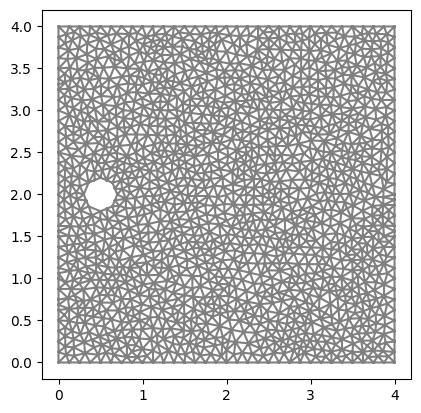

In [47]:
# Define rectangular domain
L = 4
H = 4

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [56]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 3)
QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

In [57]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**

In [58]:
# Set boundary penalty parameter gamma
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Set data that describe functional that defines the adjoint problem
#psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
#psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
psi1 = Expression(("1.0","1.0"), element = V.ufl_element())
psi2 = Expression("1.0", element = Q.ufl_element())
phi3 = Expression(("1.0","1.0"), element = V.ufl_element())

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system
solve(res == 0, w)

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system
solve(res_a == 0, wa)

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


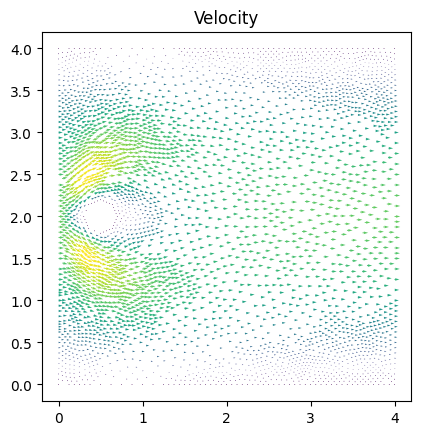

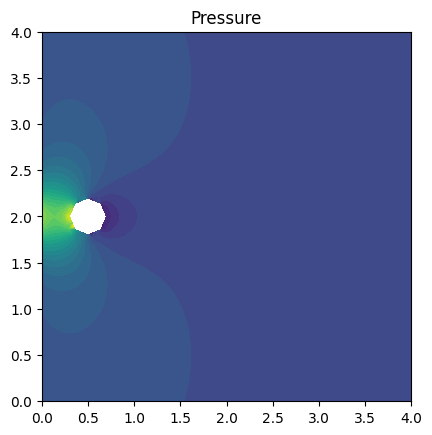

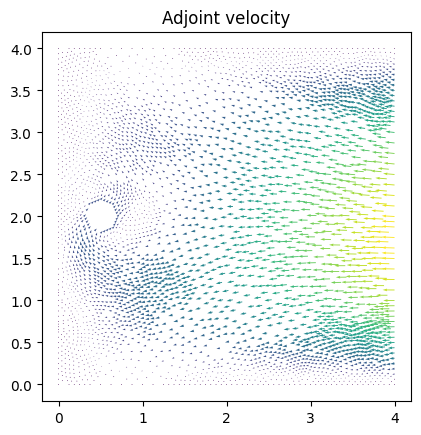

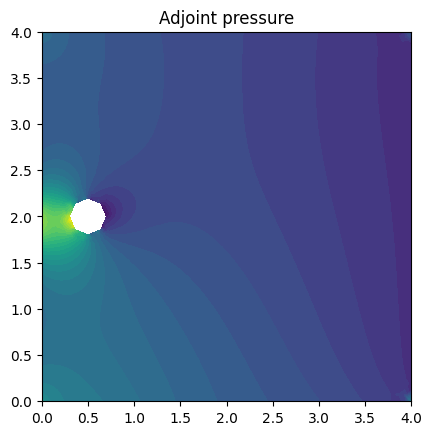

In [59]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")

plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

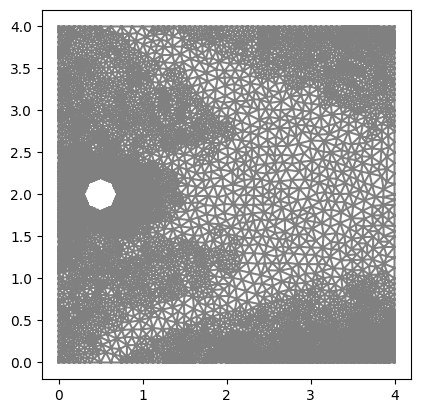

Total error = 0.028172678520162364


In [60]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()]
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err)
print(s)

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

# **Changing the Domain**
By moving the centerpoint of the circle within the original mesh, we check if there are unexpected differences within the adjoint solution and the mesh refinement. The standard solution looks like this:

![im1](https://i.imgur.com/AFNpMXc.png)

Underneath this point the variants can be found.

## **Point in Center**
![im2](https://i.imgur.com/470ESot.png)

As can be seen in the picture above, some funky things happen with the mesh refinement if the circle is placed in the center of the domain. As is expected the space right around the circle is still refined, but so are some half-oval areas at the top and bottom of the domain. If we look at the adjoint velocity and pressure graphs we see no clear reason for this. It stands to reason then that the errant mesh refinement is due to the boundary conditions reaching higher errors when the pressure is more even.

For the velocity we see that the graphs look quite similar, just that the velocity for the center point is less squished on the left side and less stretched on the right side. It generally looks quite even. The same can be said about the adjoint pressure, while there still are pressure points on the left and right sides of the circle the general pressure of the system is much more diluted with only a slight gradient in colour from the left to the right side.

## **Point at bottom**
![im1](https://i.imgur.com/6aDA0bd.png)

When the point is at the bottom, meaning it is closer to a boundary condition, we can see on the adjoint velocity graph that only one vortex forms due to the the lack of space south of the circle. It leads to a slight scattering of the velocity afer the flow has met the circle, causing the velocity to tend upwards. We can also see on the adjoint pressure graph that the high and low pressure areas also tend to the bottom of the circle, which is because of the way the flow that is constrained by the boundary conditions will press upon the circle.

Due to the upwards trend of the flow, we can see that the mesh again refines around the topmost boundary condition, but this time it refines more to the right where the flow will proceed. We can also see some channels centering towards the middle of the path underneath the circle where the mesh isn't refining. This is probably due to these parts having quite a smooth flow.

## **Point Towards Corner**
![im1](https://i.imgur.com/f3AU9qd.png)

When the point is towards the bottom left corner we can once again see on the adjoint velocity graph that there are two vortices like in the original scenario. We can also see on the pressure graph that the high pressure areas tend towards the closest boundary conditions.

The mesh refinement is quite interesting since it mostly centers around the circle just with a few differences. For one, it gets extra refinement from where the flow from over the circle concentrates and meets the boundary. A bunch of refinement also appears where the flow around the southern vortex meets the bottom border, since more resolution is needed to find the correct solution for these scenarios.

## **Point Tightly Cornered**
![im1](https://i.imgur.com/astzVI4.png)

By squeezing the point into the top right corner with only a tiny channel above for the flow to pass through we can see that the pressure keeps quite high and increases drastically where it tries to go through the small channel, leaving a smal splotch of low pressure area on the other side since the flow cant reach it easily. We can see on the adjoint velocity that the velocity gets higher the closer it gets to the circle and that the flow seems to circulate to the right of the domain, with the flow returning in from the right.

For the mesh refinement we can see that this position needed a slightly bigger area of refinement than most others. This is most probably because of how the flow has to pass through a tiny channel, and how it returns from outside of the measured area. We can also see a a significant area of refinement on the bottom leaning to the right. This is where the new flow from the right would meet the boundary condition, which can be assumed to give a higher error.

## **Point Moved Slightly Upwards**
![im1](https://i.imgur.com/9RvXnbS.png)

For the last test we just move the circle upwards slightly. We can see that the difference here is (logically) much more subtle than on the others, but it is still there. It can be seen that the adjoint velocity spreads out more to the bottom right, leading to a lower pressure to the top right.

For the mesh refinement we can see that most of the refinement centers around the circle like how it was in the original case. It can however be seen that some extra refinement is needed where the flow that returns from the top vortex hits the ceiling boundary.

## **Summary**

As can be seen in the figures, the velocity and pressure solutions look mostly similar to each other when the circle is moved, unless the circle is placed in an "extreme" location. The two vortex flow seems to be the most functioning. For the mesh refinement we can see that the spots that consistently give the most error (and therefore are the most refined) are the spots right around the circle, and the spots where the flow that is rotated around the vortices hits the boundary conditions.


# **Changing the Adjoint Problem**

By changing $\psi_1, \psi_2, \psi_3$ we can inspect how the adjoint solution changes. The different values refer to different properties of the flow, with $psi_1$ referring to the direction of the velocity, $psi_2$ referring to the pressure, and $psi_3$ reffering to the force. The default values of these variables are $\psi_1=(0,0) , \psi_2=0, \psi_3=(1,0)$, which therefore refers to the drag force in the system. By varying these values we can get different adjoint solutions for different use cases.

Below is the default setup for the $\psi$ values.

![im1](https://i.imgur.com/AFNpMXc.png)

## **Lift Force**
![im](https://i.imgur.com/LbaNrpk.png)
$\psi_1=(0,0) , \psi_2=0, \psi_3=(0,1)$

As the adjoint solution most closely related to the drag force, the lift force solution gives us a pretty recognisable graph, with two vortices on the sides of the circle albeit with one cut off by the entry condition on the left wall. It can be seen that the adjoint pressure graph shows an increase above the circle with a decrease below the circle, with the flow passing around the right side of the circle with some flowing out towards the right and some flowing back under the circle. This leads to a bigger area of mesh refinement since more of the flow has to tend to the boundary conditions.

## **Horizontal Velocity**
![im](https://i.imgur.com/CFBNUIc.png)
$\psi_1=(1,0) , \psi_2=0, \psi_3=(0,0)$

If we only refer to the horizontal velocity the adjoint solution gets very weird, with the velocity graph showing many spots where the velocity seems to be going in an unnatural direction. This shows that a lot of errors are popping up, which is confirmed by the mesh having to be refined for almost the entirety of the left side of the domain. Also of interest is that since pressure does not matter as much in this case, the adjoint pressure graph looks like a very even gradient that discretely passes from higher to lower pressures instead of varying depending on how it is affected by the flow.  

## **Vertical Velocity**
![im](https://i.imgur.com/CzyLzRP.png)
$\psi_1=(0,1) , \psi_2=0, \psi_3=(0,0)$

The vertical velocity is more of the same with many troubles in the graphs. The velocity is shown to flow around the outgoing boundary, with some smaller flows around the circle and by the boundaries. This leads to a problematic solution that cannot be easily calculated, which means that the refinement tries to refine almost everything to get a better answer. Like in the horizontal velocity case the pressure is a smooth gradient, but this time it has pressure points on the outgoing boundary, and the pressure bends around the circle slightly.

## **Pressure**
![im](https://i.imgur.com/YC0utuX.png)
$\psi_1=(0,0) , \psi_2=1, \psi_3=(0,0)$

When we refer to only pressure, we can see that the adjoint velocity moves from the outgoing boundary towards the circle. This is in reference to how the pressure escapes through the left side. The mesh refinement therefore grows towards the outgoing boundary and has some heavy usage near the circle, but in general is less used than for velocity testing.

## **Unorganized Everything**
![im](https://i.imgur.com/uH0UbrB.png)
$\psi_1=(1,1) , \psi_2=1, \psi_3=(1,1)$

Just to see what would happen I made the functional test for everything. This leads to an unstable system which really doesn't tell us very much. An interesting point is that it still has to refine less than the vertical velocity version, and I assume this is since it is not having to do purely vertical which seems to insert a lot of issues, probably due to the boundary conditions.

## **Summary**

From these different graphs it is plain to see that every value for $\phi$ gives us a unique solution. This means that it is very important to pick the right functional when refining a mesh, since otherwise the mesh may be too highly refined or not refined enough.

